In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import fields, asdict
import pickle
import sys
sys.path.insert(0,'../../') # just for jupyter  notebook
from stochvolmodels.data.option_chain import OptionChain
from stochvolmodels.utils.funcs import transform_from_tfcomplex128_to_np, slice_option_chain
import copy
import warnings
from toolz import interleave
from scipy import stats
warnings.filterwarnings('ignore')

2023-12-15 11:13:53.822163: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BTC1 = pd.read_feather('../../../resources/deribit/BTC-spot.feather')

In [3]:
BTC1.index = pd.to_datetime(BTC1.timestamp)
FR = BTC1.funding_rate.rolling(24).mean()
_id = pd.Series(FR.index, index=FR.index).apply(lambda x: x.hour) == 9
FR = FR.loc[_id]
FR.index = pd.Series(FR.index, index=FR.index).apply(lambda x: x.strftime('%Y-%m-%d'))
FR.index = pd.to_datetime(FR.index)
FR.name = 'FR'
FR *= 10_000 
FR = FR.rolling(7).sum()

In [4]:
def slice_option_chain(option_chain, ids_i):
    option_chain = copy.copy(option_chain)
    replacements = dict()
    for field in fields(option_chain):
        field_name = field.name
        option_chain_value = getattr(option_chain, field_name)
        try:
            replacements[field_name] = [option_chain_value[i] for i in ids_i]
        except:
            replacements[field_name] = option_chain_value
            
    return OptionChain(**replacements)

In [5]:
def jump_compensators(nu, eta, side):
    if side == 'p':
        return np.exp(nu)/(1-eta)-1
    elif side == 'm':
        return np.exp(nu)/(1+eta)-1

positive_jump_compensator = lambda nu_p, eta_p: jump_compensators(nu_p, eta_p, 'p')
negative_jump_compensator = lambda nu_m, eta_m: jump_compensators(nu_m, eta_m, 'm')


In [6]:
P_params = pd.read_csv('P_params.csv', index_col=0)
P_params.index = pd.Series(P_params.index).apply(lambda x: x[:10])
P_params.index = pd.to_datetime(P_params.index)

with open("Q_results_refined.pickle", "rb") as f: 
    Q_results = pickle.load(f)
    
Q_params = dict()
for date in Q_results:
    d = asdict(transform_from_tfcomplex128_to_np(Q_results[date]['measure_change_results']))
    
    d['is_pos_jump'] = Q_results[date]['is_pos_jump']
    d['is_neg_jump'] = Q_results[date]['is_neg_jump']
    if Q_results[date]['MAPE'] <= 2:
        Q_params[date] = d
    
Q_params = pd.DataFrame(Q_params).T
Q_params.index = pd.to_datetime(Q_params.index)
Q_params = Q_params.astype(np.float64)

In [7]:
def gen_jumps_premia(Q_params, P_params):
    pjp = Q_params.lambda_p * positive_jump_compensator(Q_params.nu_p, Q_params.eta_p) - P_params.lambda_p_right * positive_jump_compensator(P_params.nu_p, P_params.eta_p)
    njp = Q_params.lambda_m * negative_jump_compensator(Q_params.nu_m, Q_params.eta_m) - P_params.lambda_m_right * negative_jump_compensator(P_params.nu_m, P_params.eta_m)
    # pjp*= Q_params.sigma
    # njp*= Q_params.sigma

    pjp.index = pd.to_datetime(pjp.index)
    njp.index = pd.to_datetime(njp.index)
    pjp.name = 'pjp'
    njp.name = 'njp'
    return pjp.dropna(), njp.dropna()

In [8]:
def gen_background_jumps_premia(Q_params, P_params):
    pjp = Q_params.theta_p * positive_jump_compensator(Q_params.nu_p, Q_params.eta_p) - P_params.theta_p * positive_jump_compensator(P_params.nu_p, P_params.eta_p)
    njp = Q_params.theta_m * negative_jump_compensator(Q_params.nu_m, Q_params.eta_m) - P_params.theta_m * negative_jump_compensator(P_params.nu_m, P_params.eta_m)
    # pjp*= Q_params.sigma
    # njp*= Q_params.sigma

    pjp.index = pd.to_datetime(pjp.index)
    njp.index = pd.to_datetime(njp.index)
    pjp.name = 'background_pjp'
    njp.name = 'background_njp'
    return pjp.dropna(), njp.dropna()

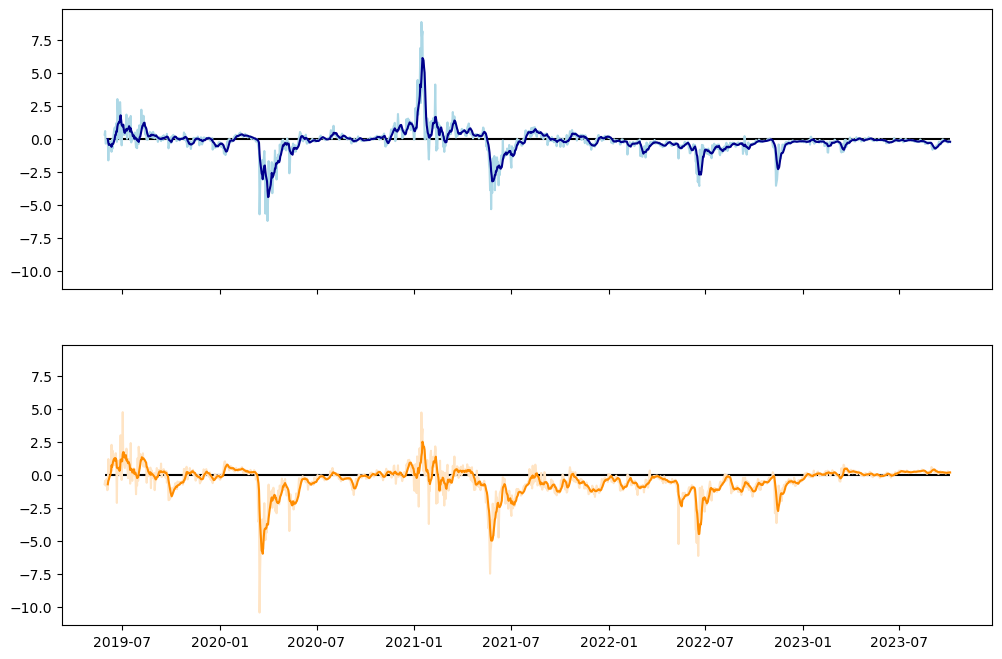

In [10]:
pjp, njp = gen_jumps_premia(Q_params, P_params)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12,8))

axs[0].plot(pjp.rolling(7).mean(), color='darkblue')
axs[0].plot(pjp, color='lightblue', zorder=-10)
axs[0].hlines(0, xmax=pjp.index.max(), xmin=pjp.index.min(), color='black', zorder=-11)

axs[1].plot(njp.rolling(7).mean(), color='darkorange')
axs[1].plot(njp, color='bisque', zorder=-10)
axs[1].hlines(0, xmax=pjp.index.max(), xmin=pjp.index.min(), color='black', zorder=-11)


In [16]:
BTC2 = pd.read_csv('../../../resources/deribit/BTC-spot-combined.csv', index_col=0)
BTC2.index = pd.Series(pd.to_datetime(BTC2.index)).apply(lambda x: x.replace(tzinfo=None))
_id = pd.Series(BTC2.index, index=BTC2.index).apply(lambda x: x.hour) == 8
BTC2 = BTC2[_id]

BTC2.index = pd.Series(pd.to_datetime(BTC2.index)).apply(lambda x: x.strftime('%Y-%m-%d'))
BTC2.index = pd.to_datetime(BTC2.index)

In [17]:
with open('BTC_option_chain.pickle', 'rb') as f:
    BTC_option_chain_dict = pickle.load(f)

In [18]:
S_arr = dict()
F_arr = dict()
tau_arr = dict()

for date in Q_results:
    option_id = Q_results[date]['option_ids']
    i = np.argmax(BTC_option_chain_dict[date].ids == option_id)

    S = BTC2.loc[date]
    F = BTC_option_chain_dict[date].forwards[i]
    tau = BTC_option_chain_dict[date].ttms[i]
    
    S_arr[date] = S.values[0]
    F_arr[date] = F[0]
    tau_arr[date] = tau


In [19]:
FS = pd.concat([pd.Series(tau_arr), pd.Series(S_arr), pd.Series(F_arr)], axis=1)
FS.columns = ['tau', 'S', 'F']
FS.loc[:,'slope'] = ((FS.F/FS.S)-1)/FS.tau
FS.index = pd.to_datetime(FS.index)

FS.loc[:, 'slope2'] = np.log(FS.F/FS.S)/FS.tau

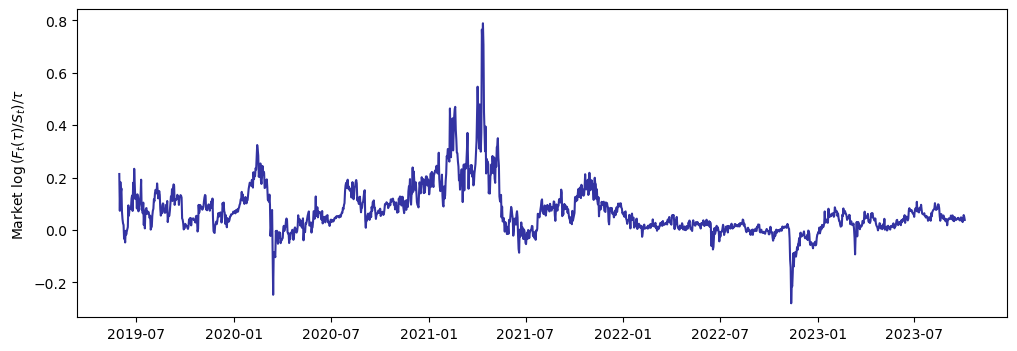

In [20]:
plt.figure(figsize=(12,4))
plt.plot(FS.slope2, color='darkblue', alpha=0.8)
plt.ylabel(r'Market $\log \left( F_t(\tau)/S_t\right)/\tau$')
# $(F(\tau)/S-1)/\tau \times 1000$
plt.savefig('futures_slope.pdf', transparent=True, bbox_inches='tight')

# plt.plot(FS.F)

In [21]:
merged_daily = BTC2.merge(FS, left_index=True, right_index=True, how='left')
merged_daily = merged_daily.merge(FR, left_index=True, right_index=True, how='left')

merged_daily = merged_daily.merge(pjp, left_index=True, right_index=True, how='left')
merged_daily = merged_daily.merge(njp, left_index=True, right_index=True, how='left')

merged_daily = merged_daily.merge(P_params, left_index=True, right_index=True, how='left')
merged_daily = merged_daily.merge(Q_params, left_index=True, right_index=True, how='left')
merged_daily = merged_daily[merged_daily.index >= '2019-01-01']

In [23]:
# Monday == 0 … Sunday == 6.
merged_daily.loc[:, 'weekday'] = pd.Series(merged_daily.index, index= merged_daily.index).apply(lambda x: x.weekday())

SECONDS_PER_YEAR = 365 * 24 * 60 * 60  # minute, seconds
merged_daily.loc[:, 't'] = (merged_daily.index - merged_daily.index[0]).total_seconds()/SECONDS_PER_YEAR

In [24]:
weekdays = pd.get_dummies(merged_daily.weekday)
weekdays.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

In [25]:
_merged_daily = merged_daily.copy()
_merged_daily.is_pos_jump = merged_daily.is_pos_jump.rolling(7).sum()
_merged_daily.is_neg_jump = merged_daily.is_neg_jump.rolling(7).sum()
_merged_daily = _merged_daily.loc[_merged_daily.weekday == 4]


In [26]:
_data_for_regression = _merged_daily.loc[:, ['slope', 'slope2', 'spot', 'pjp', 'njp', 'FR', 'is_pos_jump', 'is_neg_jump']]

_data_for_scatterplot = _data_for_regression.copy()

_data_for_regression = _data_for_regression - _data_for_regression.shift(1)

_data_for_regression = _data_for_regression.loc[_data_for_regression.isna().sum(axis=1) == 0]

In [27]:
r0 = OLS(_data_for_regression.slope2, _data_for_regression.loc[:, ['pjp', 'njp']]).fit()
r1 = OLS(_data_for_regression.slope2, _data_for_regression.loc[:, ['is_pos_jump', 'is_neg_jump']]).fit()
r2 = OLS(_data_for_regression.slope2, _data_for_regression.loc[:, ['FR']]).fit()
r3 = OLS(_data_for_regression.slope2, _data_for_regression.loc[:, ['pjp', 'njp', 'is_pos_jump', 'is_neg_jump']]).fit()
r4 = OLS(_data_for_regression.slope2, _data_for_regression.loc[:, ['pjp', 'njp', 'FR']]).fit()
r5 = OLS(_data_for_regression.slope2, _data_for_regression.loc[:, ['pjp', 'njp', 'is_pos_jump', 'is_neg_jump', 'FR']]).fit()


r0_index = r0.params.index
r1_index = r1.params.index
r2_index = r2.params.index
r3_index = r3.params.index
r4_index = r4.params.index
r5_index = r5.params.index

l = int(len(_data_for_regression)**.25)
print('lag=%i'%l)
r0 = r0.get_robustcov_results(cov_type='HAC', maxlags=l)
r1 = r1.get_robustcov_results(cov_type='HAC', maxlags=l)
r2 = r2.get_robustcov_results(cov_type='HAC', maxlags=l)
r3 = r3.get_robustcov_results(cov_type='HAC', maxlags=l)
r4 = r4.get_robustcov_results(cov_type='HAC', maxlags=l)
r5 = r5.get_robustcov_results(cov_type='HAC', maxlags=l)

r0.params = pd.Series(r0.params, index=r0_index)
r1.params = pd.Series(r1.params, index=r1_index)
r2.params = pd.Series(r2.params, index=r2_index)
r3.params = pd.Series(r3.params, index=r3_index)
r4.params = pd.Series(r4.params, index=r4_index)
r5.params = pd.Series(r5.params, index=r5_index)

lag=3


In [29]:
def make_table(r):
    r_table = pd.DataFrame(interleave([r.params, r.tvalues]))
    tuples = []

    for _id in r.params.index:
        for type in ['params', 'tvalues']:
            tuples.append((_id, type))
        
        
    index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
    r_table.index = index
    
    return r_table

In [30]:
table = pd.concat([make_table(r) for r in [r0,r1,r2,r3,r4,r5]], axis=1)
table.index = table.index.get_level_values('first')
table.columns = ['I', 'II', 'III', 'IV', 'V', 'VI']

new_index = []
for i, _id in enumerate(list(table.index)):
    if i%2==0:
        new_index.append(_id)
    else:
        new_index.append('')
        
table.index = new_index
# table = table.apply(lambda x: np.round(x, 4))
table = table.fillna('')

# add stars
for i in range(len(table)):
    if i%2==1:
        for j in range(len(table.iloc[i])):
            t = table.iloc[i].iloc[j]
            if t != '':
                p = (1-stats.t.cdf(np.abs(t), df = r0.nobs))*2
                if p <= 0.01:
                    # print(i-1, j)
                    table.iloc[i-1,j] = '%.4f'%(table.iloc[i-1].iloc[j])+'(***)'
                elif p <= 0.05:
                    # print(i-1, j)
                    table.iloc[i-1,j] = '%.4f'%(table.iloc[i-1].iloc[j])+'(**)'
                elif p <= 0.1:
                    # print(i-1, j)
                    table.iloc[i-1,j] = '%.4f'%(table.iloc[i-1].iloc[j])+'(*)'
                else:
                    # print(i-1, j)
                    table.iloc[i-1,j] = '%.4f'%(table.iloc[i-1].iloc[j])


In [31]:
R2_text = ' & '.join(['%.4f'%r.rsquared_adj for r in [r0,r1,r2,r3,r4,r5]])
R2_text

'0.1467 & 0.0866 & 0.2231 & 0.1956 & 0.2794 & 0.3107'

In [32]:
for i in range(len(table)):
    if i%2==1:
        for j in range(len(table.iloc[i])):
            t = table.iloc[i].iloc[j]
            if t != '':
                table.iloc[i, j] = '(%.4f)'%table.iloc[i, j]


In [36]:
R2_text = ' & '.join(['%.4f'%r.rsquared_adj for r in [r0,r1,r2,r3,r4,r5]])

latex = table.to_latex(index=True)
latex = latex.replace('()', '')

latex = latex.replace('pjp', '$\\gamma^+_t$')
latex = latex.replace('njp', '$\\gamma^-_t$')

latex = latex.replace('is\_pos\_jump', '$N^{(1)}_t - N^{(1)}_{t-7}$')
latex = latex.replace('is\_neg\_jump', '$N^{(2)}_t - N^{(2)}_{t-7}$')

latex = latex.replace('FR', '$r^{\\text{funding}}_{t,t-7}$')

latex = latex.replace('(*)', '$*$')
latex = latex.replace('(**)', '$**$')
latex = latex.replace('(***)', '$***$')

latex = latex.replace('lllllll', 'rSSSSSS')

latex = latex.replace('\\bottomrule',
                      '\\midrule\nAdj. $R^2$ & '
                      + R2_text + '\\\\' + '\\bottomrule')


# for reg_id in table.columns:
#     latex = latex.replace(reg_id, '{' + reg_id + '}')


latex = latex.replace('I &            II &          III &            IV &            V &            VI', '{I} & {II} & {III} &     {IV} & {V} & {VI}')

print(latex)

with open('regression_on_BTCF.tex', 'w') as f:
    f.write(latex)

\begin{tabular}{rSSSSSS}
\toprule
{} &            I &            II &          III &           IV &            V &           VI \\
\midrule
$\gamma^+_t$         &  0.0157$***$ &               &              &  0.0160$***$ &       0.0071 &    0.0075$*$ \\
            &     (2.6139) &               &              &     (3.5339) &     (1.2400) &     (1.7027) \\
$\gamma^-_t$         &   0.0132$**$ &               &              &       0.0089 &   0.0131$**$ &    0.0097$*$ \\
            &     (2.2257) &               &              &     (1.4316) &     (2.5760) &     (1.7995) \\
$N^{(1)}_t - N^{(1)}_{t-7}$ &              &    0.0102$**$ &              &  0.0112$***$ &              &    0.0073$*$ \\
            &              &      (2.1840) &              &     (3.0709) &              &     (1.8356) \\
$N^{(2)}_t - N^{(2)}_{t-7}$ &              &  -0.0179$***$ &              &  -0.0126$**$ &              &  -0.0114$**$ \\
            &              &     (-2.8429) &              &    (-2.4

In [231]:
table

,I,II,III,IV,V,VI
pjp,0.0157(***),,,0.0160(***),0.0071,0.0075(*)
,(2.6139),,,(3.5339),(1.2400),(1.7027)
njp,0.0132(**),,,0.0089,0.0131(**),0.0097(*)
,(2.2257),,,(1.4316),(2.5760),(1.7995)
is_pos_jump,,0.0102(**),,0.0112(***),,0.0073(*)
,,(2.1840),,(3.0709),,(1.8356)
is_neg_jump,,-0.0179(***),,-0.0126(**),,-0.0114(**)
,,(-2.8429),,(-2.4792),,(-2.2707)
FR,,,0.0024(***),,0.0020(***),0.0018(***)
,,,(4.6951),,(3.8976),(3.7371)


In [286]:
from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ={r:.4f}', xy=(.1, .9), xycoords=ax.transAxes)

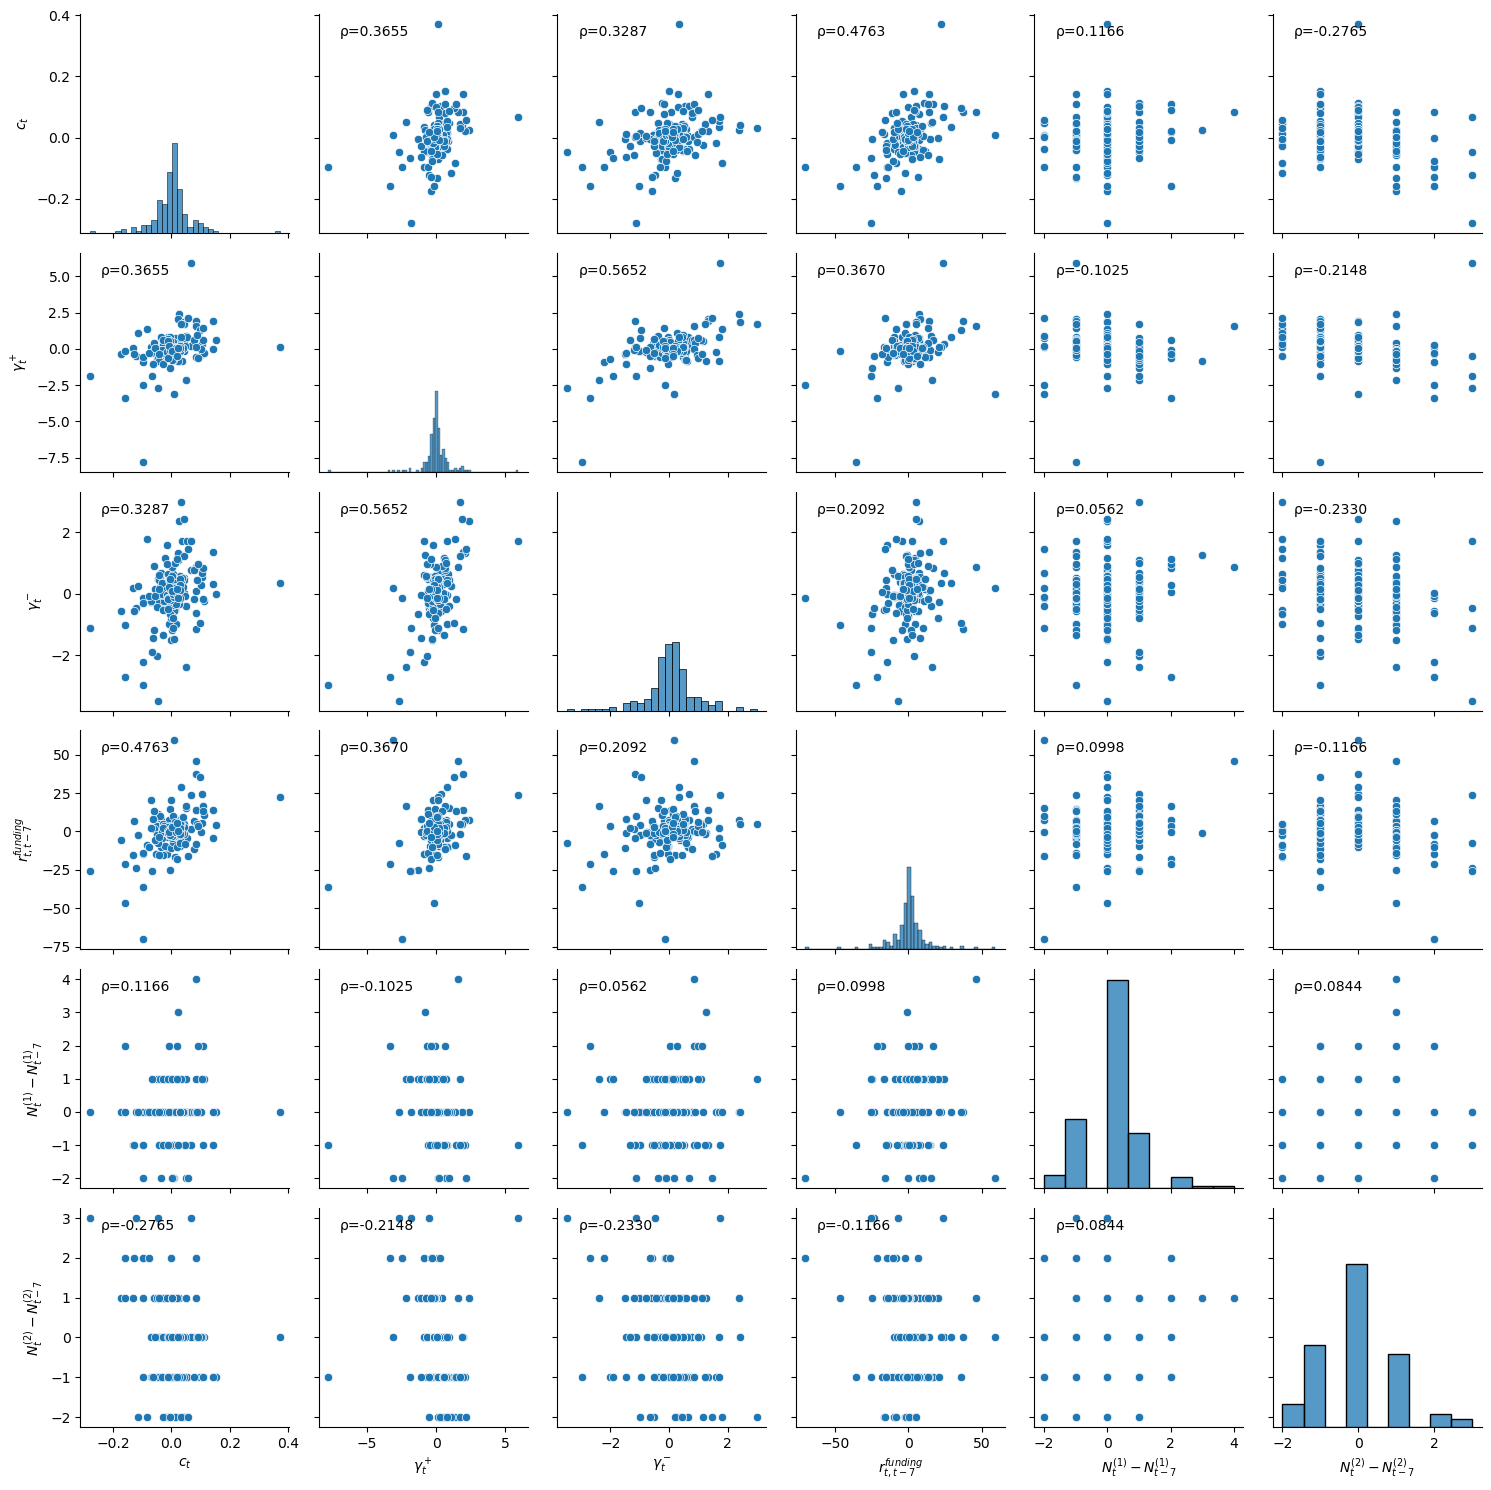

In [288]:
_df = _data_for_regression.loc[:,['slope2', 'pjp', 'njp', 'FR', 'is_pos_jump', 'is_neg_jump']]

vars_name = [r'$c_t$', r'$\gamma^+_t$', r'$\gamma^-_t$', r'$r^{funding}_{t,t-7}$', r'$N^{(1)}_t - N^{(1)}_{t-7}$', r'$N^{(2)}_t - N^{(2)}_{t-7}$']
g = sns.pairplot(_df)
g.map_lower(corrfunc)
g.map_upper(corrfunc)

for i, ax in enumerate(g.axes.flatten()[::6]):
    ax.set_ylabel(vars_name[i])
    
for i, ax in enumerate(g.axes.flatten()[30:]):
    ax.set_xlabel(vars_name[i])

plt.tight_layout()

plt.savefig('futures_vars_scatterplot.pdf', transparent=True)

In [270]:
_df.loc[:, 'total_N_jump'] = _df.is_pos_jump + _df.is_neg_jump

In [273]:
_df.loc[:,['pjp', 'njp', 'FR', 'is_pos_jump', 'is_neg_jump']].corr()

,pjp,njp,FR,is_pos_jump,is_neg_jump
pjp,1.000000,0.565182,0.367032,-0.102526,-0.214785
njp,0.565182,1.000000,0.209207,0.056178,-0.232959
FR,0.367032,0.209207,1.000000,0.099798,-0.116551
is_pos_jump,-0.102526,0.056178,0.099798,1.000000,0.084393
is_neg_jump,-0.214785,-0.232959,-0.116551,0.084393,1.000000
